In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('config', "InlineBackend.figure_formats = {'png', 'pdf'}")
from PIFilter import IIR_PI_Filter, calculate_pi_coefficients
from delay_integrator_model import DelayIntegratorPlantModel
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Control of an Idealized Delay + Integrator Plant

This notebook demonstrates the simulation and control of a simple delay-integrator system, a common abstraction for thermal or process control applications. We evaluate open-loop behavior, apply ideal and practical PI controllers, and analyze phenomena such as integrator windup and anti-windup strategies.

## System Overview

We simulate a system where the temperature evolves over time according to an integrator model with a pure delay and an optional thermal leak to ambient temperature. The model is updated at a fixed sampling rate.

## Heat Leak Model
The plant model includes a heat leak which is the same units as the gain. A heat leak equal to the control setting will result in a constant temperature.

Show the plant cooling to the ambient temperature.

Text(0.5, 1.0, 'Ambient Cooling of Object Due To Heat Leak')

Text(0.5, 0, 'Sample Number')

Text(0, 0.5, 'Temperature (K)')

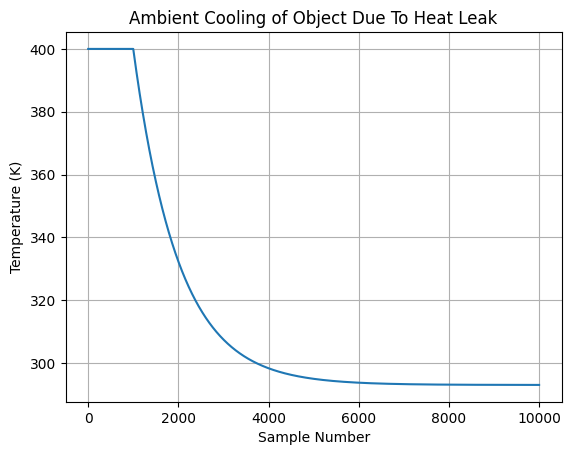

In [2]:
p = DelayIntegratorPlantModel(delay=1, gain=1, rate=1000, ambient=293, temperature=400, heat_leak=1)
data = [p.update(0) for _ in range(10 * int(p.delay * p.rate))]

plt.plot(data)
plt.title("Ambient Cooling of Object Due To Heat Leak")
plt.xlabel("Sample Number")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.savefig("ambient-heat-leak-cooling.png")
plt.show()

## Constant Control Input
To verify steady-state behavior, we apply fixed control settings and observe how the system settles at different temperatures.

Text(0.5, 1.0, 'Response with Constant Control Input')

Text(0.5, 0, 'Sample Number')

Text(0, 0.5, 'Temperature (K)')

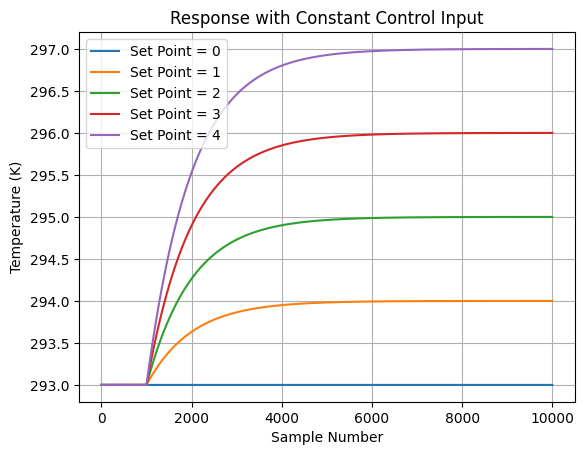

In [3]:
fig, ax = plt.subplots()

for set_point in range(5):
    d = []
    p.reset()
    p.temperature = p.ambient
    for _ in range(10*p.delay*p.rate):
        d.append(p.update(set_point))
    
    ax.plot(d, label="Set Point = %d"%set_point)

ax.set_title("Response with Constant Control Input")
ax.set_xlabel("Sample Number")
ax.set_ylabel("Temperature (K)")
plt.legend()
ax.grid(True)
plt.savefig("ambient-heat-leak-with-constant-control.png")
plt.show()

## Idealized PI Filter
Introduce an idealized filter with no output limits. Remove the heat leak to get the ideal response. To start use the SMIC tuning algorithm (https://folk.ntnu.no/skoge/publications/2012/skogestad-improved-simc-pid/old-submitted/simcpid.pdf).

We remove heat leakage and apply a PI controller tuned using the SIMC method. The filter has no output limits and thus behaves ideally.

## Output Limiting and Integrator Windup
The controller usually does not have unlimited current output so we need to introduce limits.
Adding a limit introduces windup, where the integrator accumulates error even when output is saturated, leading to instability or overshoot.

## Anti-windup Controller
To prevent windup there are several methods that can be used of increasing complexity. The simpliest is freezing the integrator value at the point the control setting is beyond the controllers capability.

Freezing the integrator leads to less overshoot than the normal state and none of the ringing occurs.

In [4]:
def plot_set(plant, temp, integral, command, title=""):
    plt.plot(temp, label="Temperature")
    plt.axhline(plant.set_point, color="gray", linestyle="--", label="Set Point")
    plt.title(f"{title}: Temperature Response")
    plt.xlabel("Sample Number")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.plot(integral, label="Integral")
    plt.title(f"{title}: Integral Term")
    plt.xlabel("Sample Number")
    plt.ylabel("Integral Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    plt.plot(command, label="Control")
    plt.title(f"{title}: Control Signal")
    plt.xlabel("Sample Number")
    plt.ylabel("Control Output")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def sim(plant, filt, npoints):
    plant.reset()
    filt.reset()    
    temp = []
    integral = []
    control = []
    
    for _ in range(npoints):
        control_setting = filt.update(p.temperature)
        control.append(control_setting)
        integral.append(filt.integral)
        temp.append(p.update(control_setting))
    return {"temp": np.array(temp), "integral": np.array(integral), "control": np.array(control)}

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.00')

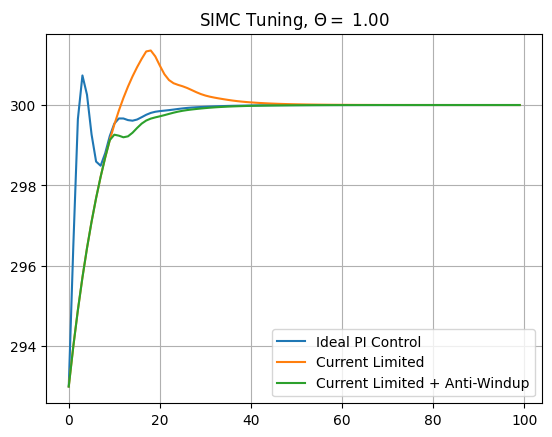

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.11')

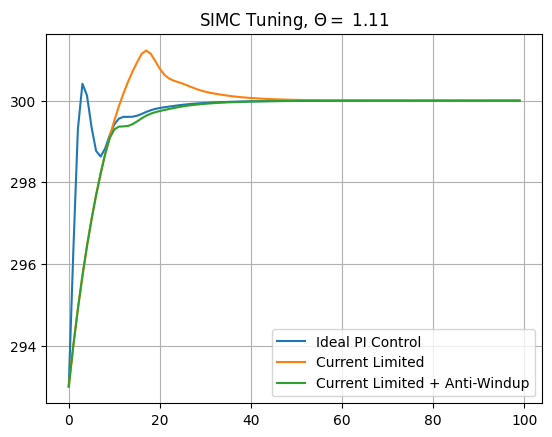

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.22')

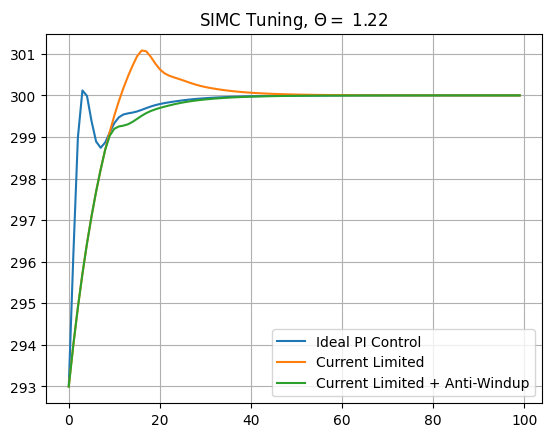

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.33')

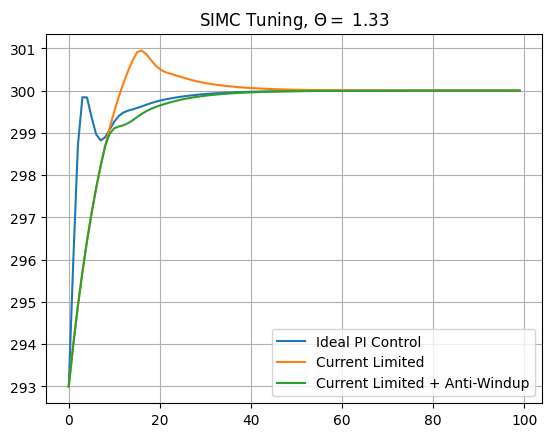

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.44')

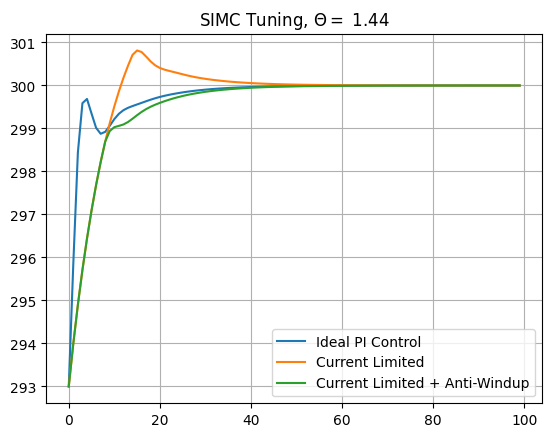

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.56')

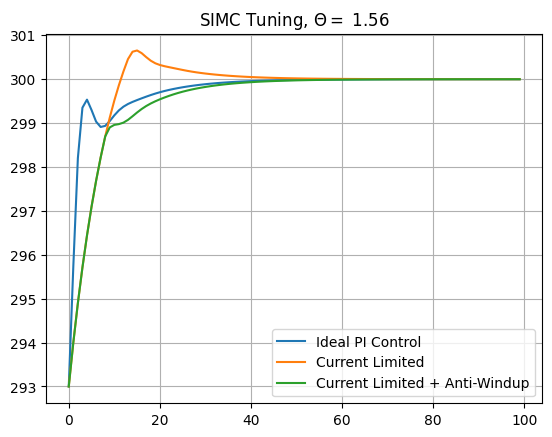

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.67')

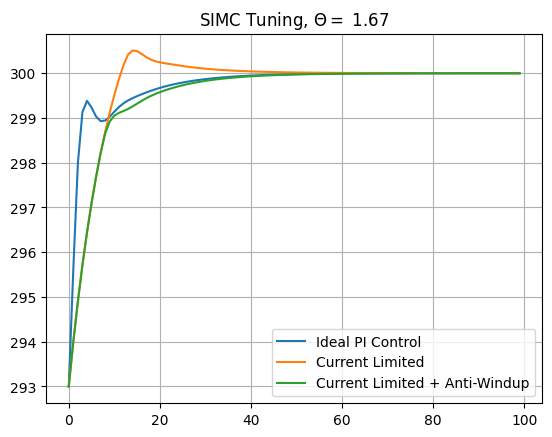

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.78')

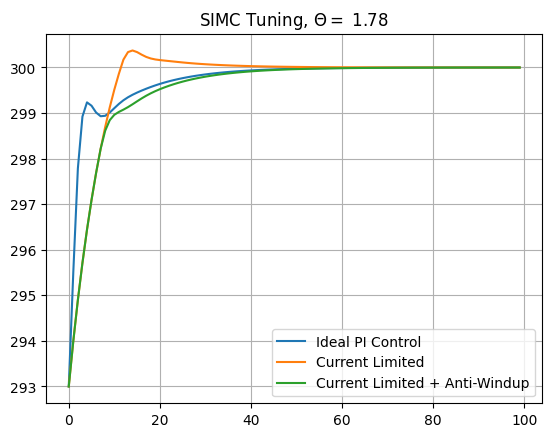

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 1.89')

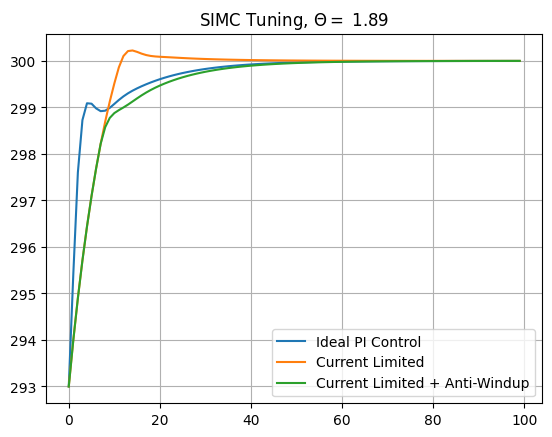

'\n    for f in filters["filter"]:\n        f.ki*=3\n    '

Text(0.5, 1.0, 'SIMC Tuning, $\\Theta=$ 2.00')

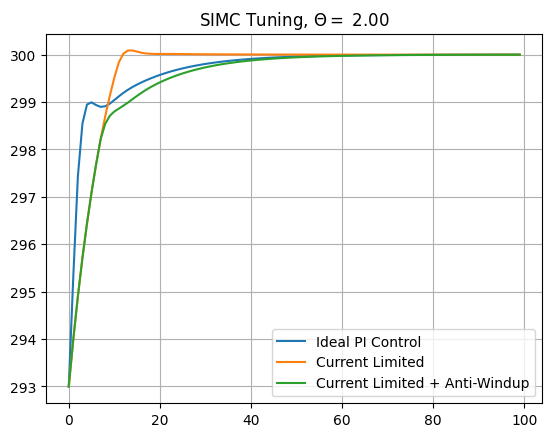

In [7]:
# Heat leak is units of A/degree -> w/ 1 Amp limit and 7 degree difference max value is 1/7 
p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=293, heat_leak=0.1)
ilim=(-1,1)
set_point = 300
for lam_factor in np.linspace(1, 2, 10):
    method = "simc"
    kp, ki = calculate_pi_coefficients(p.delay, p.gain, update_frequency=p.rate, method=method, lam_factor=lam_factor)
    ki *= p.rate
    
    filters = pd.DataFrame([
        {"title": "Ideal PI Control", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point)},
        {"title": "Current Limited", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim)},
        {"title": "Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim, antiwindup=True)},
    ])
    '''
    for f in filters["filter"]:
        f.ki*=3
    '''
    simulation_results = [sim(plant=p, filt=line["filter"], npoints=100*p.delay*p.rate) for _, line in filters.iterrows()]
    sim_df = pd.DataFrame(simulation_results)
    filters[sim_df.columns] = sim_df
    
    #for _, line in filters.iterrows():
    #    plot_set(line["filter"], line["temp"], line["integral"], line["control"], title=line["title"])
    
    fig, ax = plt.subplots()
    for _, line in filters.iterrows():
        ax.plot(line["temp"], label=line["title"])
    ax.set_title(f"{method.upper()} Tuning, $\Theta=${lam_factor: .2F}")
    plt.legend()
    plt.grid()
    plt.show()